In [1]:
# insert aima-python to python list of libraries
# needed to import aima-python
import sys
import random
import matplotlib.pyplot as plt
PATH_TO_AIMA = "../aima-python"
if PATH_TO_AIMA not in sys.path:
    sys.path.insert(0,PATH_TO_AIMA)
print(sys.path)

['../aima-python', 'C:\\Users\\Lucas\\Documents\\python\\ai-pacman', 'C:\\ProgramData\\Anaconda3\\python37.zip', 'C:\\ProgramData\\Anaconda3\\DLLs', 'C:\\ProgramData\\Anaconda3\\lib', 'C:\\ProgramData\\Anaconda3', '', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Lucas\\.ipython']


In [2]:
# import testing
from search import *
#from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
import walls

In [3]:

class CellType:
    EMPTY = 0
    WALL = 1
    DOT = 2
    GHOST = 3

class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
    
    def __getitem__(self, position):
#         x, y = position
        return self.maze[position]
    
    def __setitem__(self, new_value, position):
        self.maze[position] = new_value
    
    def __hash__(self):
        return id(self.maze)
    
    def __eq__(self, other):
        return (self.maze == other).all()
        
    def show_maze(self):
        plt.scatter(self.pac_position[1], self.pac_position[0], color='yellow')
        plt.scatter(self.goal_position[1], self.goal_position[0], color='white')
        plt.imshow(self.maze, interpolation='nearest')
        plt.show()
              
    def maze_to_array(self, maze_str, width, height):
        """
        Function that converts string maze to numpy array
        """
        maze = []
        for line in str(maze_str).splitlines():
            line = line+line[::-1]
            if line:
                line = list(line)
                for item in range(len(line)):
                    if line[item] == "|":
                        line[item] = CellType.WALL
                    else:
                        line[item] = CellType.DOT

                maze.append(line)
        return np.array(maze)         
    
    def maze_generator(self):
        """
        Function that creates the base string to generate maze
        """
        half_width = self.width//2
        maze = np.zeros((self.height, half_width))
        maze[0,:] = 1
        maze[:,0] = 1
        maze[-1,:] = 1
        maze[self.height//2-2:self.height//2+2, half_width-3::] = 1
        maze_str = []
        for line in maze:
            for item in line:
                if item == 1:
                    maze_str.append('|')
                else:
                    maze_str.append('.')
            maze_str.append('\n')
        maze_str = ''.join(maze_str)

        maze = walls.Map(half_width, self.height, maze_str)
        # verbosity option (-v)
        #maze.verbose = True
        # generate map by adding walls until there's no more room
        while maze.add_wall_obstacle(extend=True):
            pass
        
        maze_array = self.maze_to_array(maze, half_width, self.height)
        
        # insert ghosts to the maze
        for i in range(3):
            valid_positions = np.argwhere(maze_array==CellType.DOT)
            position = random.choice(valid_positions)
            maze_array[position[0],position[1]] = CellType.GHOST
        
        # pacman initial position
        valid_positions = np.argwhere(maze_array==CellType.DOT)
        self.pac_position = tuple(random.choice(valid_positions))
        self.goal_position = tuple(random.choice(valid_positions))
        self.maze = maze_array
        self.maze[self.pac_position] = CellType.EMPTY
        #self.maze.flags.writeable = False


    # maybe get shape

In [ ]:
class PacmanMazeProblem(Problem):
    """The Pacman Maze Problem."""
    
    
    def __init__(self, maze, goal_position):
        Problem.__init__(self, maze, goal_position)
        
    def actions(self, state):
        """The possible actions are the neighbors of a given node
        except if the neighbor is a ghost or a wall"""

        state.show_maze()
                
        actions = []
        y, x = state.pac_position
        directions = [         (0, -1),
                      (-1, 0),           (1,  0),
                                (0, 1)           ]
        for position in directions:
            possible_pos = (y+position[1], x+position[0])
            maze_value = state.maze[possible_pos]
            if maze_value == CellType.DOT:
                actions.append(possible_pos)
        return actions

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state."""
        
        new_state = Maze(state.width, state.height)
        new_state.maze = state.maze
        new_state.goal_position = state.goal_position
        
        new_state.maze[state.pac_position] = CellType.EMPTY
        new_state.pac_position = action
        new_state.maze[state.pac_position] = CellType.EMPTY

        return new_state
    
    def goal_test(self, state):
        """Return True if the state is a goal."""
        
        return state.pac_position == self.goal

    def path_cost(self, c, state1, action, state2):
        """
        If action makes pacman eat a DOT this path is less costly
        """
        if state1.maze[action] == CellType.DOT:
            return c + 1
        else:
            return c + 2
    
#     def h1():  

In [5]:
MAZE_WIDTH = 26
MAZE_HEIGHT = 25
maze_array = Maze(MAZE_WIDTH, MAZE_HEIGHT)
maze_array.maze_generator()

(23, 6)
(19, 18)


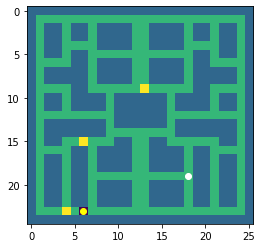

In [6]:
print(maze_array.pac_position)
print(maze_array.goal_position)
maze_array.show_maze()

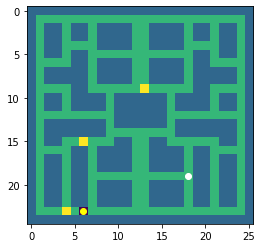

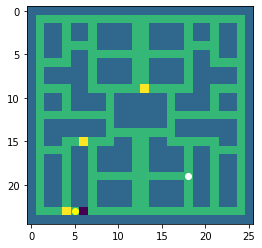

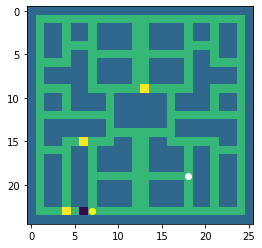

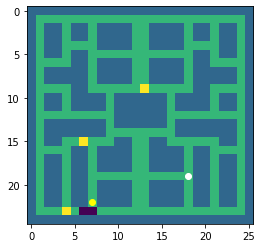

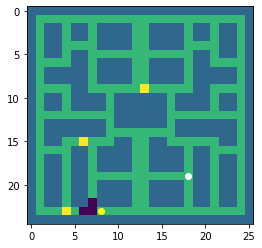

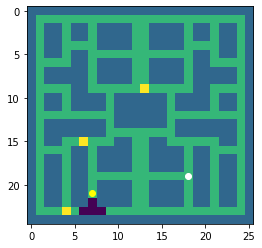

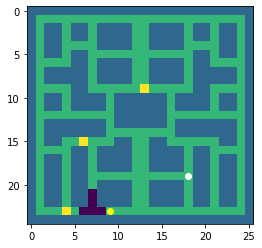

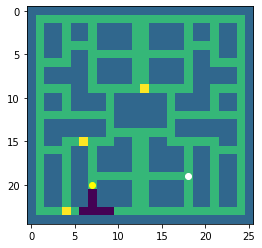

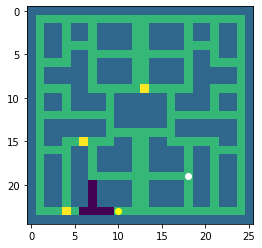

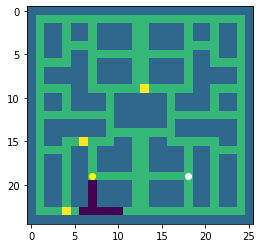

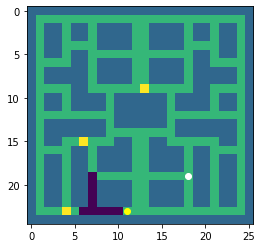

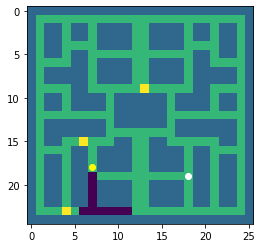

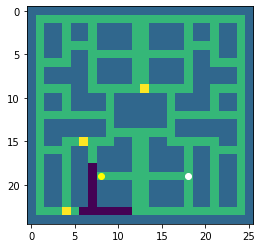

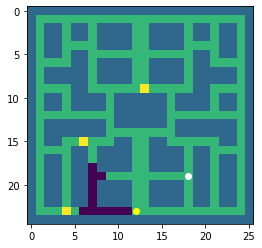

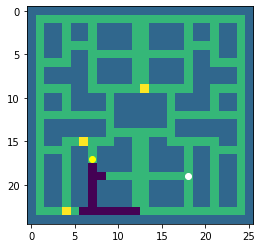

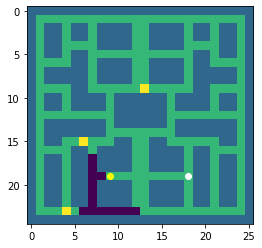

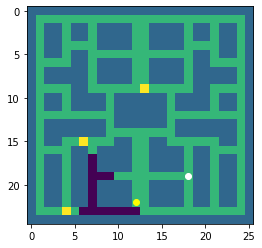

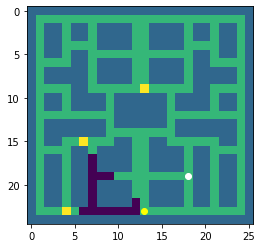

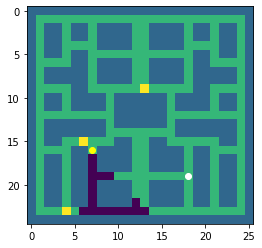

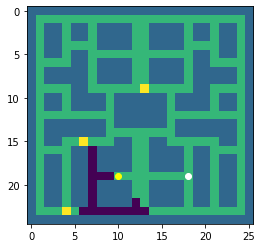

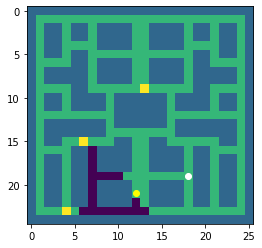

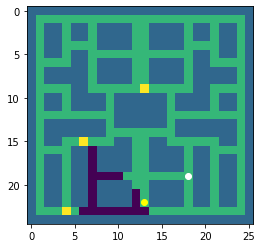

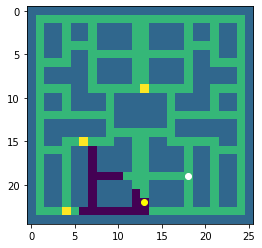

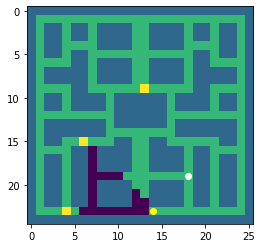

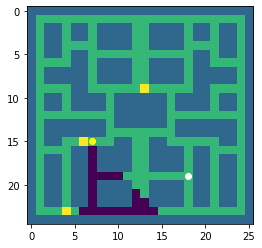

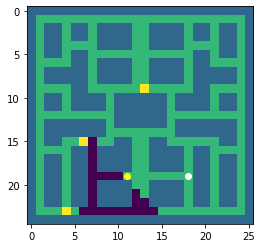

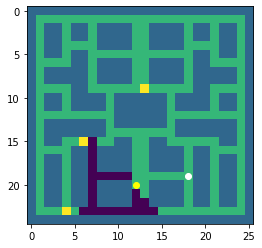

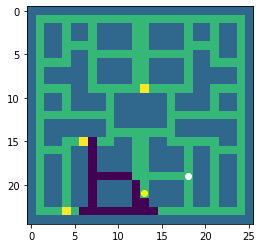

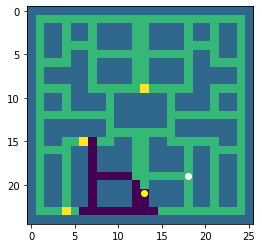

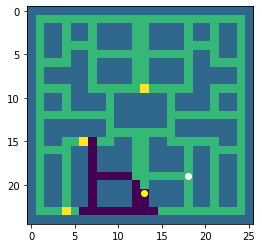

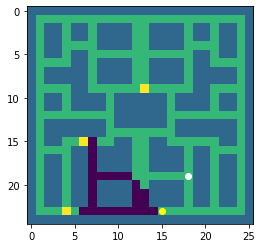

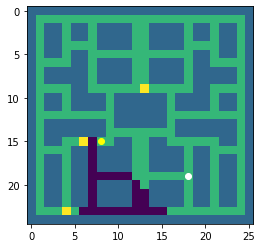

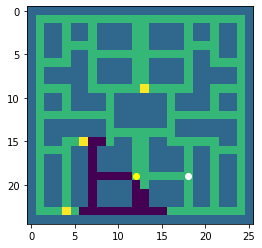

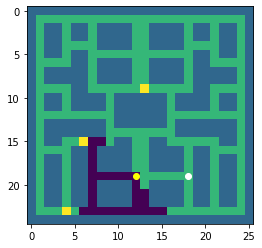

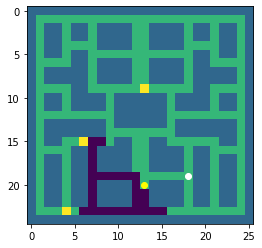

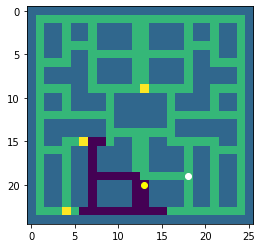

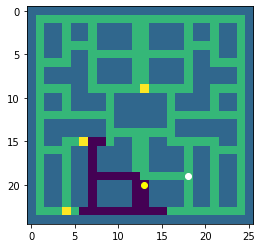

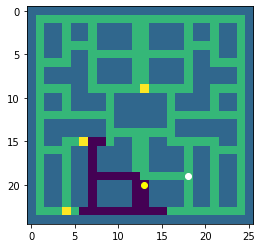

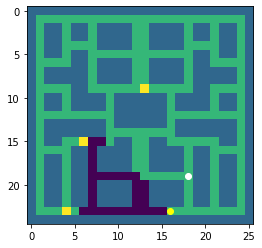

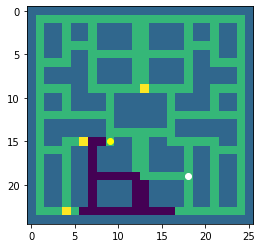

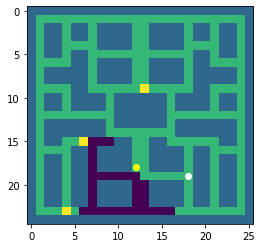

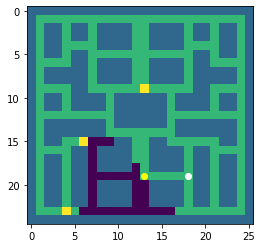

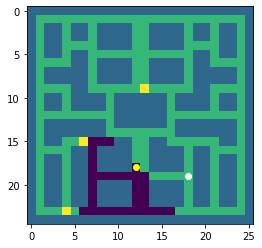

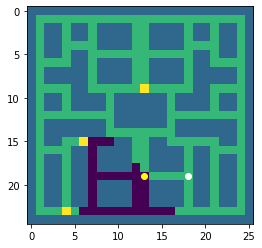

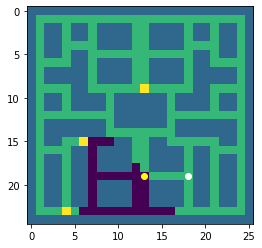

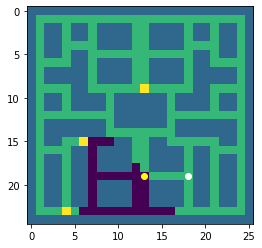

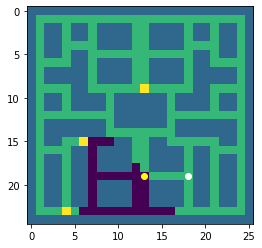

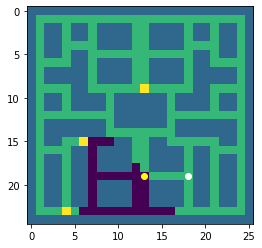

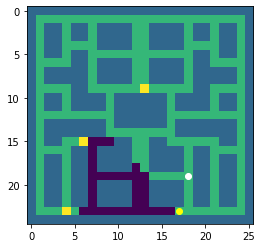

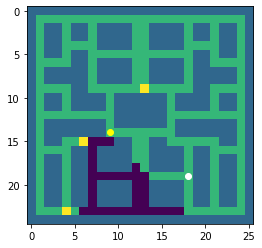

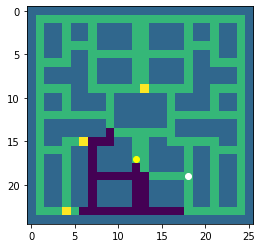

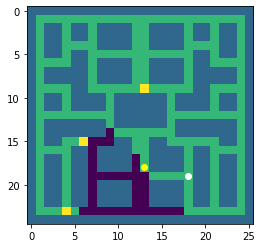

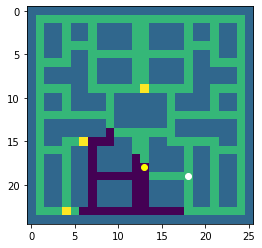

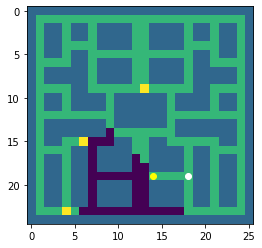

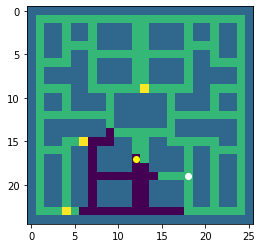

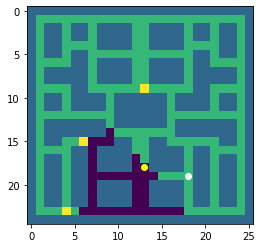

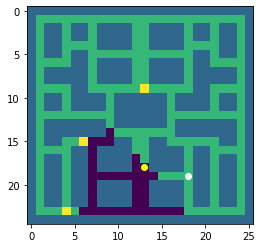

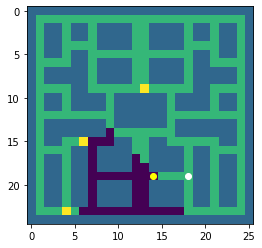

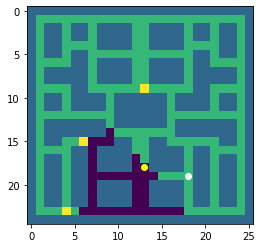

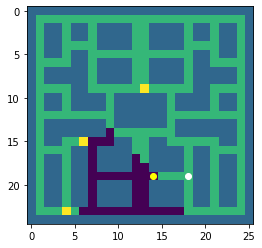

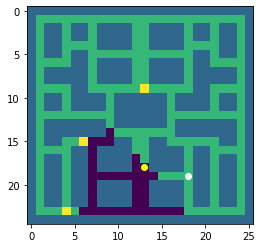

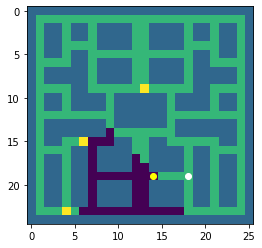

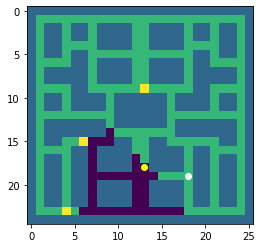

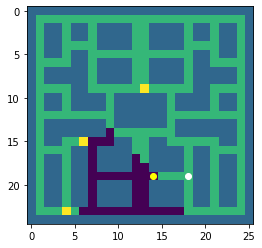

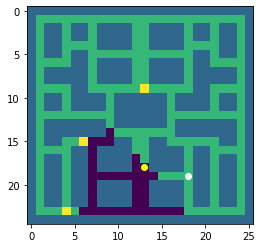

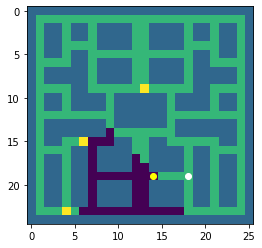

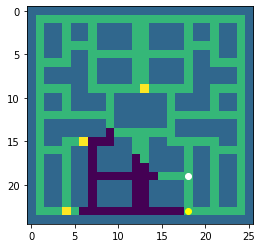

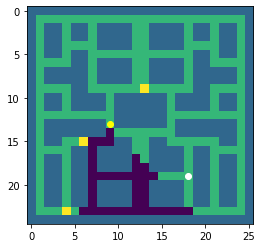

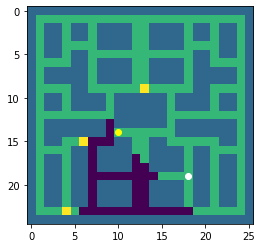

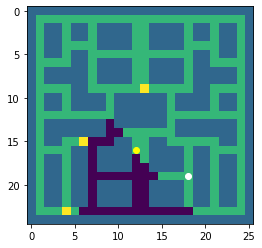

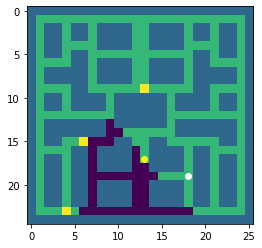

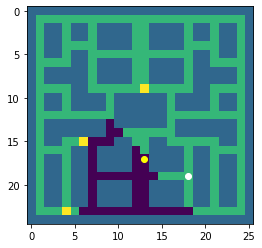

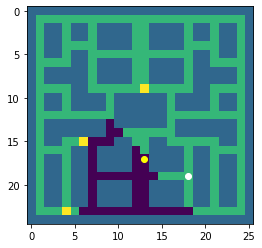

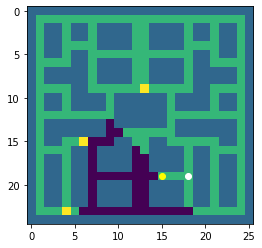

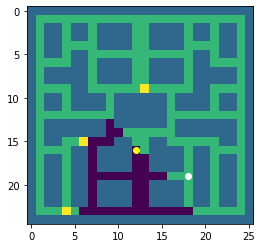

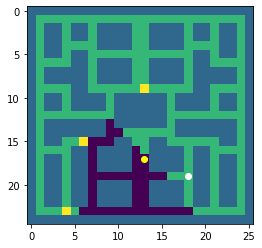

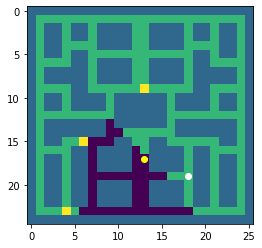

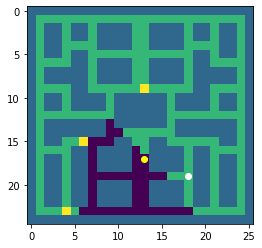

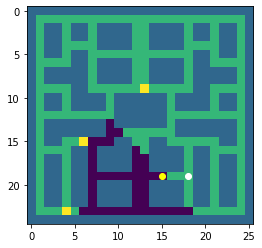

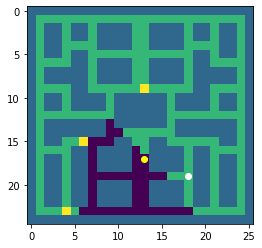

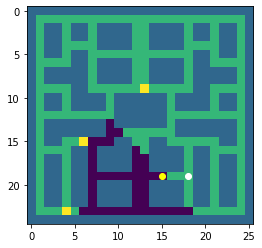

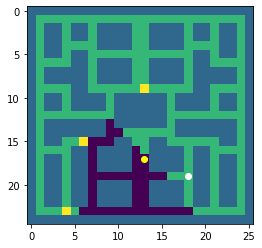

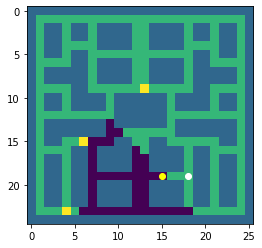

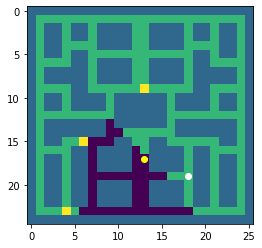

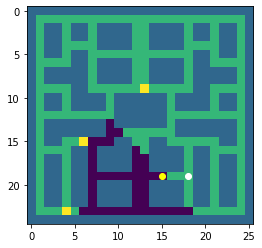

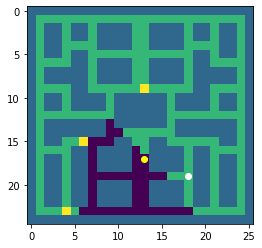

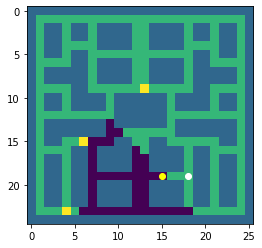

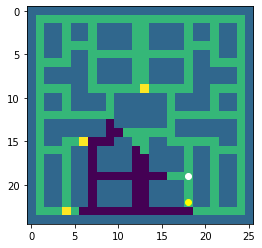

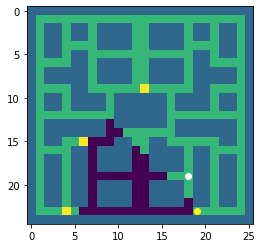

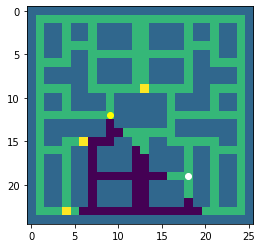

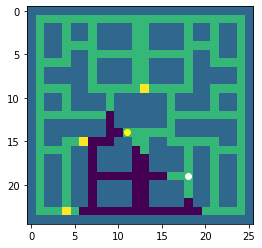

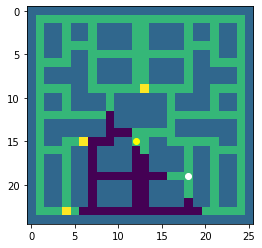

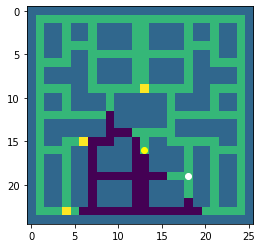

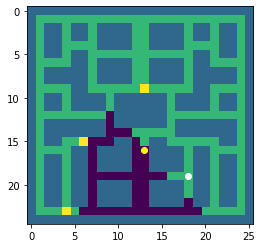

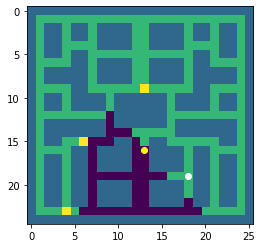

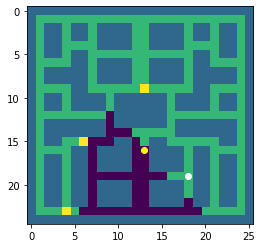

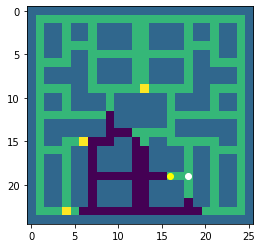

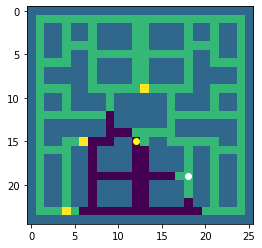

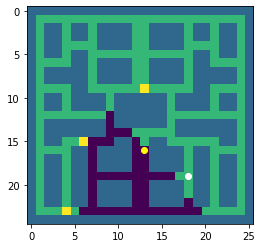

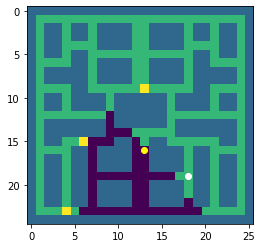

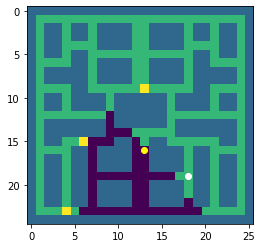

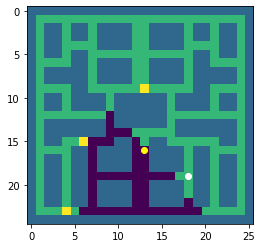

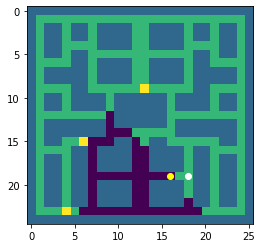

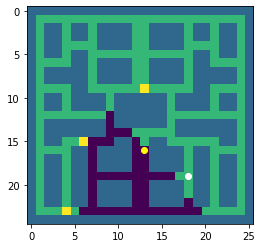

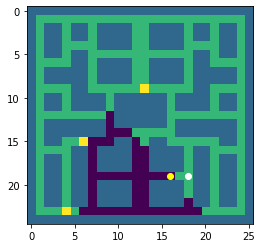

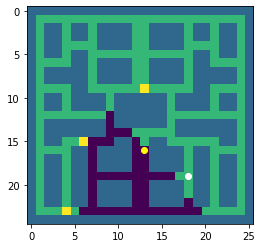

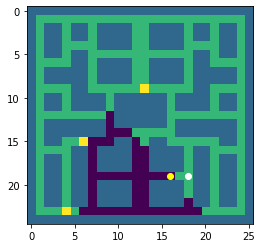

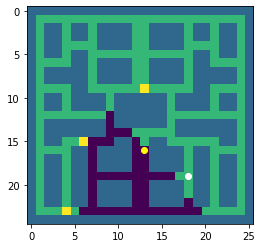

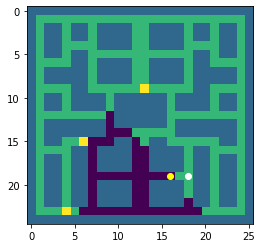

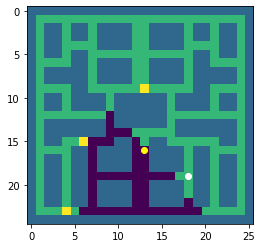

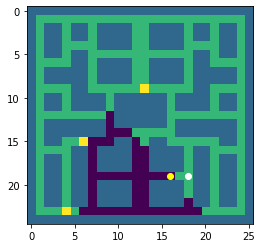

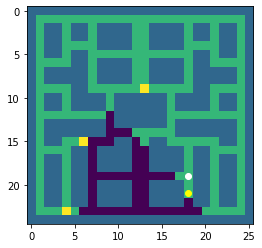

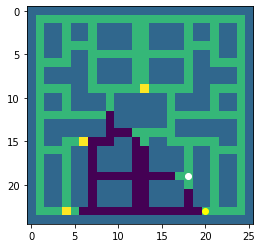

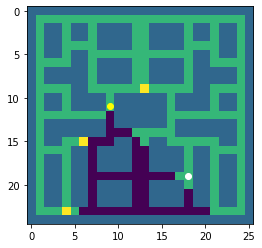

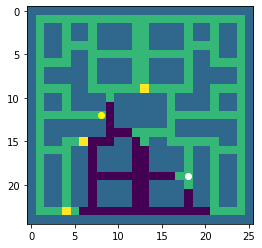

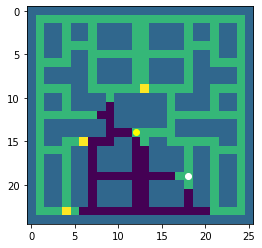

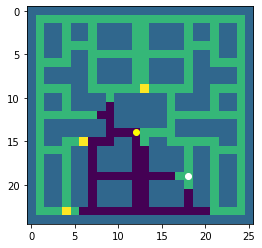

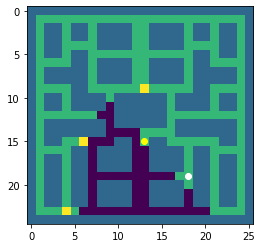

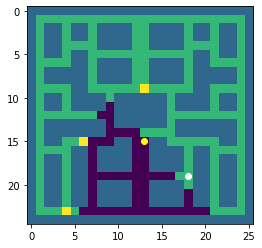

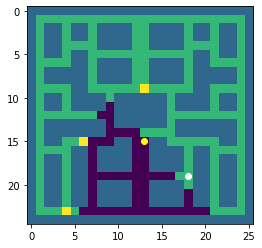

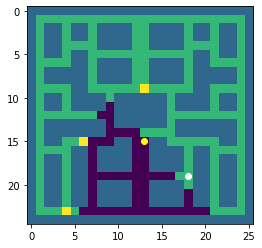

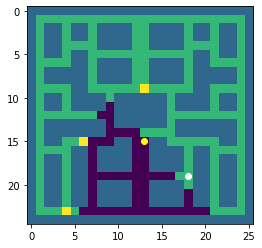

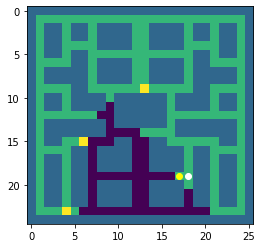

In [7]:
problem = PacmanMazeProblem(maze_array, maze_array.goal_position)
solution = breadth_first_graph_search(problem)

In [8]:
print(solution.solution())
print(solution.path_cost)

[(23, 7), (22, 7), (21, 7), (20, 7), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (19, 16), (19, 17), (19, 18)]
16
